# Fake News Detection with Adversarial Normalization

## Set-up Stuff

In [ ]:
!pip install transformers

In [ ]:
# Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim
from torch.autograd import Variable, Function
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import pickle
from collections import OrderedDict
from time import time
from os import path

In [ ]:
# import pdb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

cuda:0
Wed Dec 16 20:32:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |     10MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+

## Loading Data

In [ ]:
source_folder = '/content/drive/My Drive/Projects/Academic/NN/data/'

In [ ]:
destination_folder = '/content/drive/My Drive/Projects/Academic/NN/final_output/'

In [ ]:
unbalanced_train_data_path = source_folder + "train_unbalanced.csv"
unbalanced_test_data_path = source_folder + "test_unbalanced.csv"
unbalanced_validation_data_path = source_folder + "validation_unbalanced.csv"

In [ ]:
def load_from_csv(path):
    print("Loading:", path) 
    return pd.read_csv(path, encoding="utf-8", quotechar='"', engine="c", error_bad_lines=False, warn_bad_lines=True)

unbal_data_train = load_from_csv(unbalanced_train_data_path)
unbal_data_test = load_from_csv(unbalanced_test_data_path)
unbal_data_val = load_from_csv(unbalanced_validation_data_path)

Loading: /content/drive/My Drive/Projects/Academic/NN/data/train_unbalanced.csv
Loading: /content/drive/My Drive/Projects/Academic/NN/data/test_unbalanced.csv
Loading: /content/drive/My Drive/Projects/Academic/NN/data/validation_unbalanced.csv


In [ ]:
class FNDataset(Dataset):
    def __init__(self, news, targets, keywords, indexes, tokenizer, max_tokens):
        self._news = news
        self.targets = targets
        self.keywords = keywords
        self.indexes = indexes
        self.tokenizer = tokenizer
        self.max_tokens = max_tokens

        self.keyword_2_int = {}
        self.int_2_keyword = {}
        for i, keyword in enumerate(set(keywords.tolist())):
            self.keyword_2_int[keyword] = i
            self.int_2_keyword[i] = keyword
        
    def __len__(self):
        return len(self._news)
    
    def __getitem__(self, item):
        news_item = self._news[item]
        target = self.targets[item]
        keyword = self.keyword_2_int[self.keywords[item]]
        encoding = self.tokenizer.encode_plus(
            news_item,
            add_special_tokens=True,
            max_length=self.max_tokens,
            truncation=True,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        item_index = self.indexes[item]
        
        # news_item, input_ids, attention_mask, target, keyword, item index
        return  news_item, \
                encoding['input_ids'].flatten(), \
                encoding['attention_mask'].flatten(), \
                torch.tensor(target, dtype=torch.long), \
                torch.tensor(keyword, dtype=torch.long), \
                item_index

In [ ]:
def get_data_loader(df, tokenizer, max_tokens, batch_size, shuffle=True):
    return DataLoader(
        FNDataset(
            df.title_content.to_numpy(),
            df.fake.to_numpy(),
            df.keyword.to_numpy(),
            df.index.to_numpy(),
            tokenizer,
            max_tokens
        ),
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=4
    )

In [ ]:
ADV_CLASSES = len(
    set(
        list(unbal_data_train.keyword.unique()) + \
        list(unbal_data_test.keyword.unique()) + \
        list(unbal_data_val.keyword.unique())
        )
    )

In [ ]:
MAX_TOKENS = 512
BATCH_SIZE = 8

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
unbal_train_data_loader = get_data_loader(unbal_data_train.sample(12_000, random_state=1001), tokenizer, MAX_TOKENS, BATCH_SIZE)

In [ ]:
unbal_test_data_loader = get_data_loader(unbal_data_test, tokenizer, MAX_TOKENS, BATCH_SIZE)

In [ ]:
unbal_val_data_loader = get_data_loader(unbal_data_val, tokenizer, MAX_TOKENS, BATCH_SIZE)

## Model Setup

In [ ]:
# LAMBDA_ARG = 1
class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return (grad_output * - 1)

In [ ]:
# Define Network

class FANN(nn.Module):

    def __init__(self, 
                hidden_dim=1024,
                pre_trained_model_name='bert-base-cased',
                bert_max_tokens=512,
                dropout=0.2,
                fnews_classes=2,
                fnews_col="fake",
                use_adv=True,
                use_pooled=True,
                adv_classes=-1):
        super(FANN, self).__init__()

        assert not use_adv or adv_classes > 1, \
            "Adversarial network requires at least 2 classes for adversary network"
        assert fnews_classes >= 2, "Fake news classes must be at least 2"

        self.hidden_dim             = hidden_dim
        self.pre_trained_model_name = pre_trained_model_name
        self.bert_max_tokens        = bert_max_tokens
        self.dropout                = dropout
        self.fnews_classes          = fnews_classes
        self.fnews_col              = fnews_col
        self.use_adv                = use_adv
        self.use_pooled             = use_pooled
        self.adv_classes            = adv_classes

        self.bert = BertModel.from_pretrained(self.pre_trained_model_name)
        self.bert_dims = self.bert.config.hidden_size

        self.base_in = self.bert_dims if self.use_pooled else self.bert_max_tokens * self.bert_dims
        self.base_out = self.bert_dims

        self.base_seq = nn.Sequential(OrderedDict([
            ('base_linear',  nn.Linear(self.base_in, self.base_out)),
            ('base_act',     nn.LeakyReLU()),
        ]))

        # Fake News Classifier
        self.fnews_classifier = nn.Sequential(OrderedDict([
            ('fn_linear',    nn.Linear(self.bert_dims, self.fnews_classes)),
            ('fn_softmax',   nn.Softmax(dim=1))
        ]))

        # Adverssarial Classifier
        if self.use_adv:
            self.adv_classifier = nn.Sequential(OrderedDict([
                ('adv_linear',  nn.Linear(self.bert_dims, self.adv_classes)),
                ('adv_softmax', nn.Softmax(dim=1))
            ]))

        self.init_weights()

    def init_weights(self):
        mean, std = 0.0, 0.001
        def normal_init(m):
            if isinstance(m, nn.Linear):
                m.weight.data.normal_(mean, std)
                if m.bias.data is not None:
                    m.bias.data.zero_()

        def init_w(m):
            for block in self._modules:
                try:
                    for m in self._modules[block]:
                        normal_init(m)
                except:
                    normal_init(block)

        self.bert.init_weights()
        self.base_seq.apply(init_w)
        self.fnews_classifier.apply(init_w)
        if self.use_adv:
            self.adv_classifier.apply(init_w)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        bert_embedded, bert_pooled = bert_output[0], bert_output[1]
        base_output = None
        if self.use_pooled:
            base_output = self.base_seq(bert_pooled)
        else:
            bo_shape = bert_embedded.shape # view(batch size, token_length * bert_dims)
            embedded_output = bert_embedded.view(bo_shape[0], bo_shape[1] * bo_shape[2])
            base_output = self.base_seq(embedded_output)

        predicted_fnews_class = self.fnews_classifier(base_output)

        predicted_adv_class = None
        if self.use_adv:
            predicted_adv_class = self.adv_classifier(ReverseLayerF.apply(base_output))
        
        return predicted_fnews_class, predicted_adv_class

In [ ]:
def eval_model(model, data_loader, loss_fn, device, print_outputs=False):
    model = model.eval()
    
    losses_fn = []
    losses_adv = []
    correct_pred_fn = 0
    correct_pred_adv = 0
    
    n_examples = len(data_loader) * data_loader.batch_size

    with torch.no_grad():
        model.to(device)
        loss_fn.to(device)
        for news_item, input_ids, attention_mask, targets, keywords, item_id in data_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            targets = targets.to(device)
            if model.use_adv:
                keywords = keywords.to(device)

            fn_outputs, adv_outputs = model(input_ids, attention_mask)
            if print_outputs:
                print(fn_outputs, adv_outputs)
            _, fn_preds = torch.max(fn_outputs, dim=1)
            fn_loss = loss_fn(fn_outputs, targets)
            losses_fn.append(fn_loss.item())
            correct_pred_fn += torch.sum(fn_preds == targets)

            if model.use_adv and adv_outputs is not None:
                _, adv_preds = torch.max(adv_outputs, dim=1)
                adv_loss = loss_fn(adv_outputs, keywords)
                losses_adv.append(adv_loss.item())
                correct_pred_adv += torch.sum(adv_preds == keywords)

    return {
        "acc_pred_fn": correct_pred_fn.double().item() / n_examples if correct_pred_fn is not 0 else 0,
        "avg_loss_fn": np.mean(losses_fn) if len(losses_fn) > 0 else 0,
        "acc_pred_adv": correct_pred_adv.double().item() / n_examples if correct_pred_adv is not 0 else 0,
        "avg_loss_adv": np.mean(losses_adv) if len(losses_adv) > 0 else 0
    }

In [ ]:
# Training Function

def train(model,
          optimizer,
          criterion,
          train_loader,
          val_loader,
          num_epochs):
    
    adversarial = model.use_adv

    global_step = 0
    total_steps = num_epochs * len(train_loader)

    general_losses = []

    fn_acc = []
    fn_losses = []
    fn_correct_predictions = 0

    adv_losses, adv_correct_predictions, adv_acc = None, None, None
    if adversarial:
        adv_losses = []
        adv_correct_predictions = 0
        adv_acc = []

    model.to(device)
    criterion.to(device)

    print_digits = len(str(num_epochs))

    # training loop
    mark_batch_every = max(int(len(train_loader) / 100), 1)
    model.train()
    print("." * (100 + len("EPOCH #   ") + print_digits + 1))
    for epoch in range(num_epochs):
        print("EPOCH #", str(epoch).zfill(print_digits), end=" ")
        model.train()
        
        epoch_general_losses, epoch_fn_losses, epoch_adv_losses = [], [], []
        epoch_fn_acc, epoch_adv_acc = [], []
        
        batch = 0
        epoch_start = int(time() * 1_000)
        for news_item, input_ids, attention_mask, targets, keywords, item_id in train_loader:
            if batch % mark_batch_every == 0:
                print(".", end="")
            batch += 1
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            targets = targets.to(device)
            if adversarial:
                keywords = keywords.to(device)

            fn_outputs, adv_outputs = model(input_ids, attention_mask)
            _, fn_preds = torch.max(fn_outputs, dim=1)

            fn_loss = criterion(fn_outputs, targets)
            epoch_fn_losses.append(fn_loss.item())

            fn_correct_predictions += torch.sum(fn_preds == targets)

            fn_accuracy = (targets == fn_preds.squeeze()).float().mean()
            epoch_fn_acc.append(fn_accuracy.item())
            
            loss = fn_loss
            
            if adversarial and adv_outputs is not None:
                _, adv_preds = torch.max(adv_outputs, dim=1)

                adv_loss = criterion(adv_outputs, keywords)
                epoch_adv_losses.append(adv_loss.item())

                adv_correct_predictions += torch.sum(adv_preds == keywords)

                adv_accuracy = (keywords == adv_preds.squeeze()).float().mean()
                epoch_adv_acc.append(adv_accuracy.item())

                loss = fn_loss + adv_loss

            epoch_general_losses.append(loss.item())

            loss.backward()
            optimizer.step()
            
            optimizer.zero_grad()
        
        epoch_end = int(time() * 1_000)

        general_losses.append(np.mean(epoch_general_losses))

        fn_losses.append(np.mean(epoch_fn_losses))
        fn_acc.append(np.mean(epoch_fn_acc))

        if adversarial:
            adv_losses.append(np.mean(epoch_adv_losses))
            adv_acc.append(np.mean(epoch_adv_acc))

        print(" -- ", (epoch_end - epoch_start), "ms", sep="")
        print("LOSS:", general_losses[-1])
        print("LOSS FN:", fn_losses[-1])
        if adversarial:
            print("LOSS ADV:", adv_losses[-1])

        if epoch % 5 == 0:
            print("Evaluating for epoch #", epoch)
            
            train_eval_res = eval_model(model, train_loader, criterion, device)
            val_eval_res = eval_model(model, val_loader, criterion, device)
            
            print(
                'Epoch [{}/{}]: Train: {:.4f}, {:.4f} {}; Val: {:.4f}, {:4f} {};'.format(
                    epoch, num_epochs,
                    train_eval_res["acc_pred_fn"], train_eval_res["avg_loss_fn"],
                    "({:.4f}, {:.4f})".format(train_eval_res["acc_pred_adv"], train_eval_res["avg_loss_adv"]) if adversarial else "",
                    val_eval_res["acc_pred_fn"], val_eval_res["avg_loss_fn"],
                    "({:.4f}, {:.4f})".format(val_eval_res["acc_pred_adv"], val_eval_res["avg_loss_adv"]) if adversarial else ""
                )
            )

            model.train()
            model.to(device)
            criterion.to(device)
    print('Finished Training!')

    log_data = {
        "general_losses":           general_losses,
        "fn_accuracies":            fn_acc,
        "fn_losses":                fn_losses,
        "fn_correct_predictions":   fn_correct_predictions,
    }

    if adversarial:
        log_data.update({
            "adv_losses":               adv_losses,
            "adv_correct_predictions":  adv_correct_predictions,
            "adv_accuracies":           adv_acc,
        })


    return model, log_data

In [ ]:
def get_predictions(model, data_loader, results_df, col_prefix, device):
    model = model.eval()

    COL_PRED_FAKE = col_prefix + "_pred_fake"
    COL_PRED_KEYWORD = col_prefix + "_pred_keyword"

    results_df[COL_PRED_FAKE] = pd.Series(dtype=np.int32)
    if model.use_adv:
        results_df[COL_PRED_KEYWORD] = pd.Series(dtype=np.int32)

    with torch.no_grad():
        model.to(device)
        for news_item, input_ids, attention_mask, targets, keywords, item_id in data_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            targets = targets.to(device)
            if model.use_adv:
                keywords = keywords.to(device)

            fn_outputs, adv_outputs = model(input_ids, attention_mask)

            _, fn_preds = torch.max(fn_outputs, dim=1)

            adv_preds = None
            if model.use_adv and adv_outputs is not None:
                _, adv_preds = torch.max(adv_outputs, dim=1)

            for i in range(len(news_item)):
                if results_df.title_content[item_id[i].item()] == news_item[i]:
                    results_df[COL_PRED_FAKE].iat[item_id[i].item()] = fn_preds[i].item()
                    if adv_preds is not None:
                        results_df[COL_PRED_KEYWORD].iat[item_id[i].item()] = adv_preds[i].item()

    return results_df

## Training & Eval

In [ ]:
LEARNING_RATE = 1e-06
EPOCHS = 10
OUTPUT_LABEL = "final-"

In [ ]:
model_num = 1
def get_run_label(prefix=OUTPUT_LABEL):
    return prefix + str(model_num).zfill(3)

### SIMPLE - UNBALANCED

In [ ]:
model = FANN(use_adv=False)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, list(model.parameters())), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [ ]:
SIMPLE_SAVE_PATH = destination_folder + "fann_model_simple-" + get_run_label() + ".pytorch"
if path.exists(SIMPLE_SAVE_PATH):
    model = torch.load(SIMPLE_SAVE_PATH)
    print("Loaded model from", SIMPLE_SAVE_PATH)
else:
    _, log = train(
        model, optimizer, criterion, 
        unbal_train_data_loader, unbal_val_data_loader,
        num_epochs=EPOCHS
    )
    pickle.dump(log, open(destination_folder + "simple_model_train_log.pickle", "wb" ))
    torch.save(model, SIMPLE_SAVE_PATH)

Loaded model from /content/drive/My Drive/Projects/Academic/NN/final_output/fann_model_simple-final-001.pytorch


In [ ]:
res = {}

In [ ]:
res["train"] = eval_model(model, unbal_train_data_loader, criterion, device)
res["train"]

{'acc_pred_adv': 0,
 'acc_pred_fn': 0.8909166666666667,
 'avg_loss_adv': 0,
 'avg_loss_fn': 0.41858205236991247}

In [ ]:
res["validation"] = eval_model(model, unbal_val_data_loader, criterion, device)
res["validation"]

{'acc_pred_adv': 0,
 'acc_pred_fn': 0.8832386363636363,
 'avg_loss_adv': 0,
 'avg_loss_fn': 0.4270823427221992}

In [ ]:
res["test"] = eval_model(model, unbal_test_data_loader, criterion, device)
res["test"]

{'acc_pred_adv': 0,
 'acc_pred_fn': 0.8711656441717791,
 'avg_loss_adv': 0,
 'avg_loss_fn': 0.43611402440899966}

In [ ]:
pickle.dump(res, open(destination_folder + "simple_model_eval_res.pickle", "wb" ))

In [ ]:
get_predictions(model, unbal_train_data_loader, unbal_data_train, 'su', device)
get_predictions(model, unbal_test_data_loader, unbal_data_test, 'su', device)
get_predictions(model, unbal_val_data_loader, unbal_data_val, 'su', device)

,domain,type,content,updated_at,title,fake,has_mk_climate change,has_mk_business,has_mk_energy,has_mk_renewables,has_mk_health,has_mk_food,has_mk_biodiversity,has_mk_sustainable business,has_mk_coal,has_mk_fracking,has_mk_politics,has_mk_science,has_mk_china,has_mk_ebola,has_mk_cuba,has_mk_cop21,has_mk_pipelines,has_mk_russia,has_mk_tips,has_mk_transportation,has_mk_donald trump,has_mk_united states,has_mk_barack obama,has_mk_hillary clinton,has_mk_economics,has_mk_news,has_mk_big government,has_mk_finance,has_mk_markets,has_mk_analysis,has_mk_zerohedge,has_mk_zero hedge,has_mk_wikileaks,has_mk_syria,...,has_author_carl arbogast,has_author_the onion,has_author_el mito,has_author_egberto willies,has_author_james phibbs,has_author_martin walsh,has_author_israel shamir,has_author_p. ghose,has_author_andrea ruth,has_author_brandon morse,has_author_kira davis,has_author_paul kersey,has_author_robert roth,has_author_goyim must die,has_author_dr. eowyn,has_author_pamela geller,has_author_joan mccarter,has_author_kerry eleveld,has_author_sexy-author-bio,has_author_border-color,has_author_border-top-width,has_author_michael snyder,has_author_ed tracey,has_author_because without america,has_author_there is no free world.,has_author_joe cunningham,has_author_sara r,has_author_charles perrin,has_author_follow on twitter,has_author_denise oliver velez,has_author_c.j. hopkins,has_author_mark anderson,has_author_nick kollerstrom,sample_weights,title_content,content_length,title_length,total_length,keyword,su_pred_fake
0,washingtonexaminer.com,political,"President Trump called Camp David a ""very spec...",2018-02-07 23:39:33.852696,Trump calls Camp David 'a very special place' ...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1540427,Trump calls Camp David 'a very special place' ...,159,13,159,politics,0.0
1,zerohedge.com,conspiracy,The problem with government is it elevates peo...,2018-02-07 23:39:33.852696,bearsecutor,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1702435,bearsecutor <ENDTITLE> \n The problem with gov...,27,1,27,politics,1.0
2,sputniknews.com,bias,The Gold Rush didn't only take human lives but...,2018-02-07 23:39:33.852696,Apocalyptic Tourism: Top-7 Blood-Curdling Ghos...,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1702435,Apocalyptic Tourism: Top-7 Blood-Curdling Ghos...,150,6,150,china,1.0
3,washingtonexaminer.com,political,The Environmental Protection Agency on Thursda...,2018-02-02 01:19:41.756664,EPA levels record $27 million fine for renewab...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1540427,EPA levels record $27 million fine for renewab...,376,10,376,politics,0.0
4,dailycaller.com,political,Obama’s mishandling of economy has voters look...,2018-02-07 23:39:33.852696,"The DC Morning – July 13, 2010",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1540427,"The DC Morning – July 13, 2010 <ENDTITLE> \n O...",800,7,800,politics,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3511,sputniknews.com,bias,US President Donald Trump's solo press confere...,2018-02-07 23:39:33.852696,Trump's Presser: 'A Brilliant Takedown of Corr...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1702435,Trump's

In [ ]:
unbal_data_train.to_csv(destination_folder + "train_pred_outputs_simple.csv", columns=["su_pred_fake"])
unbal_data_test.to_csv(destination_folder + "test_pred_outputs_simple.csv", columns=["su_pred_fake"])
unbal_data_val.to_csv(destination_folder + "val_pred_outputs_simple.csv", columns=["su_pred_fake"])

### ADVERSARIAL

In [ ]:
model_adv = FANN(adv_classes=ADV_CLASSES, use_adv=True)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, list(model_adv.parameters())), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [ ]:
ADV_SAVE_PATH = destination_folder + "fann_model_adv-" + get_run_label() + ".pytorch"
if path.exists(ADV_SAVE_PATH):
    model_adv = torch.load(ADV_SAVE_PATH)
    print("Loaded model from", ADV_SAVE_PATH)
else:
    _, log_adv = train(
        model_adv, optimizer, criterion, 
        unbal_train_data_loader, unbal_val_data_loader,
        num_epochs=EPOCHS
    )
    pickle.dump(log_adv, open(destination_folder + "adversarial_model_train_log.pickle", "wb"))
    torch.save(model_adv, ADV_SAVE_PATH)

Loaded model from /content/drive/My Drive/Projects/Academic/NN/final_output/fann_model_adv-final-001.pytorch


In [ ]:
res_adv = {}

In [ ]:
res_adv["train"] = eval_model(model_adv, unbal_train_data_loader, criterion, device)
res_adv["train"]

{'acc_pred_adv': 0.00175,
 'acc_pred_fn': 0.91025,
 'avg_loss_adv': 3.0069282801946002,
 'avg_loss_fn': 0.4402759485046069}

In [ ]:
res_adv["validation"] = eval_model(model_adv, unbal_val_data_loader, criterion, device)
res_adv["validation"]

{'acc_pred_adv': 0.008238636363636363,
 'acc_pred_fn': 0.8897727272727273,
 'avg_loss_adv': 3.0065241260962052,
 'avg_loss_fn': 0.4533728661862287}

In [ ]:
res_adv["test"] = eval_model(model_adv, unbal_test_data_loader, criterion, device)
res_adv["test"]

{'acc_pred_adv': 0.006134969325153374,
 'acc_pred_fn': 0.8908486707566462,
 'avg_loss_adv': 3.0059133702260583,
 'avg_loss_fn': 0.4539998555232167}

In [ ]:
pickle.dump(res_adv, open(destination_folder + "adversarial_model_eval_res.pickle", "wb"))

In [ ]:
get_predictions(model_adv, unbal_train_data_loader, unbal_data_train, 'au', device)
get_predictions(model_adv, unbal_test_data_loader, unbal_data_test, 'au', device)
get_predictions(model_adv, unbal_val_data_loader, unbal_data_val, 'au', device)

,domain,type,content,updated_at,title,fake,has_mk_climate change,has_mk_business,has_mk_energy,has_mk_renewables,has_mk_health,has_mk_food,has_mk_biodiversity,has_mk_sustainable business,has_mk_coal,has_mk_fracking,has_mk_politics,has_mk_science,has_mk_china,has_mk_ebola,has_mk_cuba,has_mk_cop21,has_mk_pipelines,has_mk_russia,has_mk_tips,has_mk_transportation,has_mk_donald trump,has_mk_united states,has_mk_barack obama,has_mk_hillary clinton,has_mk_economics,has_mk_news,has_mk_big government,has_mk_finance,has_mk_markets,has_mk_analysis,has_mk_zerohedge,has_mk_zero hedge,has_mk_wikileaks,has_mk_syria,...,has_author_el mito,has_author_egberto willies,has_author_james phibbs,has_author_martin walsh,has_author_israel shamir,has_author_p. ghose,has_author_andrea ruth,has_author_brandon morse,has_author_kira davis,has_author_paul kersey,has_author_robert roth,has_author_goyim must die,has_author_dr. eowyn,has_author_pamela geller,has_author_joan mccarter,has_author_kerry eleveld,has_author_sexy-author-bio,has_author_border-color,has_author_border-top-width,has_author_michael snyder,has_author_ed tracey,has_author_because without america,has_author_there is no free world.,has_author_joe cunningham,has_author_sara r,has_author_charles perrin,has_author_follow on twitter,has_author_denise oliver velez,has_author_c.j. hopkins,has_author_mark anderson,has_author_nick kollerstrom,sample_weights,title_content,content_length,title_length,total_length,keyword,su_pred_fake,au_pred_fake,au_pred_keyword
0,washingtonexaminer.com,political,"President Trump called Camp David a ""very spec...",2018-02-07 23:39:33.852696,Trump calls Camp David 'a very special place' ...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1540427,Trump calls Camp David 'a very special place' ...,159,13,159,politics,0.0,0.0,11.0
1,zerohedge.com,conspiracy,The problem with government is it elevates peo...,2018-02-07 23:39:33.852696,bearsecutor,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1702435,bearsecutor <ENDTITLE> \n The problem with gov...,27,1,27,politics,1.0,1.0,18.0
2,sputniknews.com,bias,The Gold Rush didn't only take human lives but...,2018-02-07 23:39:33.852696,Apocalyptic Tourism: Top-7 Blood-Curdling Ghos...,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1702435,Apocalyptic Tourism: Top-7 Blood-Curdling Ghos...,150,6,150,china,1.0,1.0,18.0
3,washingtonexaminer.com,political,The Environmental Protection Agency on Thursda...,2018-02-02 01:19:41.756664,EPA levels record $27 million fine for renewab...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1540427,EPA levels record $27 million fine for renewab...,376,10,376,politics,0.0,0.0,11.0
4,dailycaller.com,political,Obama’s mishandling of economy has voters look...,2018-02-07 23:39:33.852696,"The DC Morning – July 13, 2010",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1540427,"The DC Morning – July 13, 2010 <ENDTITLE> \n O...",800,7,800,politics,0.0,0.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3511,sputniknews.com,bias,US President Donald Trump's solo press confere...,2018-02-07 23:39:33.852696,Trump's Presser: 'A Brilliant Takedown of Corr...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1702435,Tru

In [ ]:
unbal_data_train["au_pred_keyword"].unique()

array([18., nan, 11.])

In [ ]:
def convert_to_keyword_name(k, data_loader):
    return data_loader.dataset.int_2_keyword.get(int(k) if not np.isnan(k) else -1, "unk")
    
unbal_data_train["au_pred_keyword_name"] = unbal_data_train["au_pred_keyword"].apply(lambda k: convert_to_keyword_name(k, unbal_train_data_loader))
unbal_data_test["au_pred_keyword_name"] = unbal_data_test["au_pred_keyword"].apply(lambda k: convert_to_keyword_name(k, unbal_train_data_loader))
unbal_data_val["au_pred_keyword_name"] = unbal_data_val["au_pred_keyword"].apply(lambda k: convert_to_keyword_name(k, unbal_train_data_loader))

In [ ]:
unbal_data_train["au_pred_keyword_name"].unique()

array(['fracking', 'unk', 'renewables'], dtype=object)

In [ ]:
unbal_data_train.to_csv(destination_folder + "train_pred_outputs_adversarial.csv", columns=["au_pred_fake", "au_pred_keyword", "au_pred_keyword_name"])
unbal_data_test.to_csv(destination_folder + "test_pred_outputs_adversarial.csv", columns=["au_pred_fake", "au_pred_keyword", "au_pred_keyword_name"])
unbal_data_val.to_csv(destination_folder + "val_pred_outputs_adversarial.csv", columns=["au_pred_fake", "au_pred_keyword", "au_pred_keyword_name"])

## Analysis

### Metrics Utils

In [ ]:
# Remove samples unused in training
unbal_data_train_full = unbal_data_train
unbal_data_train = unbal_data_train.dropna(subset=["su_pred_fake", "au_pred_fake", "au_pred_keyword"])

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_auc_score
from tabulate import tabulate

In [ ]:
def compute_all_metrics(data, silent=False):
    def print_header(header):
        print(header, "-" * (100 - len(header) - 1))
    def print_prac(p, r, a, f):
        print("Precision: {:.4f}; Recall: {:.4f}; Accuracy: {:.4f}; F1: {:.4f}".format(p, r, a, f))
    def print_footer():
        print("-" * 100, end="\n\n")
    def print_binary(header, p, r, a, f, report, confusion, roc_auc, t_counts, p_counts):
        if not silent:
            print_header(header)
            print_prac(p, r, a, f)
            
            print("CLASSIFICATION REPORT:")
            print(report)
            
            print("CONFUSION MATRIX:")
            print(confusion)
            
            print("ROC AUC CURVE:")
            print(roc_auc)
            
            print("TRUE COUNTS")
            print(t_counts[0])
            print(t_counts[1])
            
            print("PRED COUNTS")
            print(p_counts[0])
            print(p_counts[1])
            
            print_footer()

    def binary_scoring(y_true, y_pred, target_names):
        p = precision_score(y_true, y_pred)
        r = recall_score(y_true, y_pred)
        a = accuracy_score(y_true, y_pred)
        f = f1_score(y_true, y_pred)

        if len(y_true.unique()) == 1 and len(y_pred.unique()) == 1:
            target_names = [target_names[y_true.unique()[0]]]

        report = classification_report(y_true, y_pred, target_names=target_names)
        confusion = confusion_matrix(y_true, y_pred)

        roc_auc = roc_auc_score(y_true, y_pred) if len(y_true.unique()) > 1 else None

        true_counts = y_true.value_counts(normalize=False), y_true.value_counts(normalize=True)
        pred_counts = y_pred.value_counts(normalize=False), y_pred.value_counts(normalize=True)

        return p, r, a, f, report, confusion, roc_auc, true_counts, pred_counts

    sim_p, sim_r, sim_a, sim_f, sim_report, sim_conf, sim_roc, sim_tc, sim_pc = \
        binary_scoring(data.fake, data.su_pred_fake, ["real", "fake"])
    
    adv_p, adv_r, adv_a, adv_f, adv_report, adv_conf, adv_roc, adv_tc, adv_pc = \
        binary_scoring(data.fake, data.au_pred_fake, ["real", "fake"])
    
    print_binary("SIMPLE MODEL",
                 sim_p, sim_r, sim_a, sim_f, sim_report, sim_conf, sim_roc, sim_tc, sim_pc)
    print_binary("ADVERSARIAL MODEL",
                 adv_p, adv_r, adv_a, adv_f, adv_report, adv_conf, adv_roc, adv_tc, adv_pc)

    return {
        "simple_fake_real": {
            "precision score": sim_p,
            "recall score": sim_r,
            "accuracy score": sim_a, 
            "f1 score": sim_f,
            "classficiation report": sim_report,
            "confusion matrix": sim_conf,
            "roc auc": sim_roc,
            "true counts": sim_tc,
            "pred counts": sim_pc
        },
        "adversarial_fake_real": {
            "precision score": adv_p,
            "recall score": adv_r,
            "accuracy score": adv_a, 
            "f1 score": adv_f,
            "classficiation report": adv_report,
            "confusion matrix": adv_conf,
            "roc auc": adv_roc,
            "true counts": adv_tc,
            "pred counts": adv_pc
        }
    }

In [ ]:
def subclass_bias_scoring(data, bias_col, bias_value, silent=False):
    def subset_scoring(y_true, y_pred):
        p = precision_score(y_true, y_pred)
        r = recall_score(y_true, y_pred)
        a = accuracy_score(y_true, y_pred)
        f = f1_score(y_true, y_pred)

        roc_auc = roc_auc_score(y_true, y_pred) if len(y_true.unique()) > 1 else None

        true_counts = y_true.value_counts(normalize=False), y_true.value_counts(normalize=True)
        pred_counts = y_pred.value_counts(normalize=False), y_pred.value_counts(normalize=True)

        tc_0 = true_counts[0][0] if 0 in true_counts[0] else 0
        tc_1 = true_counts[0][1] if 1 in true_counts[0] else 0
        pc_0 = pred_counts[0][0] if 0 in pred_counts[0] else 0
        pc_1 = pred_counts[0][1] if 1 in pred_counts[0] else 0

        ntc_0 = true_counts[1][0] if 0 in true_counts[1] else 0.0
        ntc_1 = true_counts[1][1] if 1 in true_counts[1] else 0.0
        npc_0 = pred_counts[1][0] if 0 in pred_counts[1] else 0.0
        npc_1 = pred_counts[1][1] if 1 in pred_counts[1] else 0.0

        return p, r, a, f, roc_auc, tc_0, tc_1, pc_0, pc_1, ntc_0, ntc_1, npc_0, npc_1

    subclass_only = data[data[bias_col] == bias_value]
    wout_subclass = data[data[bias_col] != bias_value]

    metrics_sim_full = subset_scoring(data.fake,            data.su_pred_fake)
    metrics_sim_only = subset_scoring(subclass_only.fake,   subclass_only.su_pred_fake)
    metrics_sim_wout = subset_scoring(wout_subclass.fake,   wout_subclass.su_pred_fake)

    metrics_adv_full = subset_scoring(data.fake,            data.au_pred_fake)
    metrics_adv_only = subset_scoring(subclass_only.fake,   subclass_only.au_pred_fake)
    metrics_adv_wout = subset_scoring(wout_subclass.fake,   wout_subclass.au_pred_fake)

    if not silent:
        print(
            tabulate(
            [
                ['SIMPLE/FULL', *metrics_sim_full],
                ['SIMPLE/ONLY', *metrics_sim_only],
                ['SIMPLE/WOUT', *metrics_sim_wout],
                ['ADVERS/FULL', *metrics_adv_full],
                ['ADVERS/ONLY', *metrics_adv_only],
                ['ADVERS/WOUT', *metrics_adv_wout]
            ], 
            headers=[
                        "Model/Subset", "Precision", "Recall", "Accuracy", "F-1", 
                        "ROC AUC",
                        "# TRUE REAL", "# TRUE FAKE", "# PRED REAL", "# PRED FAKE",
                        "% TRUE REAL", "% TRUE FAKE", "% PRED REAL", "% PRED FAKE"
                    ]
            )
        )
    return {
        'SIMPLE/FULL': metrics_sim_full,
        'SIMPLE/ONLY': metrics_sim_only,
        'SIMPLE/WOUT': metrics_sim_wout,
        'ADVERS/FULL': metrics_adv_full,
        'ADVERS/ONLY': metrics_adv_only,
        'ADVERS/WOUT': metrics_adv_wout
    }


In [202]:
colors = ["#FF8C00", "#9932CC"]

def plot_simadv_comp(met_train, met_test, met_val, plot_metric, title, y_label, 
                     out_path,
                     bar_width=0.25, colors=colors):
    
    sim_train_acc = met_train["simple_fake_real"][plot_metric]
    sim_test_acc = met_test["simple_fake_real"][plot_metric]
    sim_val_acc = met_val["simple_fake_real"][plot_metric]

    adv_train_acc = met_train["adversarial_fake_real"][plot_metric]
    adv_test_acc = met_test["adversarial_fake_real"][plot_metric]
    adv_val_acc = met_val["adversarial_fake_real"][plot_metric]

    heights_sim_bars = [sim_train_acc, sim_test_acc, sim_val_acc]
    heights_adv_bars = [adv_train_acc, adv_test_acc, adv_val_acc]

    sim_bar_pos = np.arange(len(heights_sim_bars))
    adv_bar_pos = [x + bar_width for x in sim_bar_pos]

    fig = plt.figure(figsize=(10, 8))
    fig.patch.set_facecolor('white')

    plt.xlabel('model', fontweight='bold')
    plt.xticks([r + bar_width for r in range(len(heights_sim_bars))], ['train', 'test', 'valid.'])

    plt.bar(sim_bar_pos, heights_sim_bars, color=colors[0], width=bar_width, edgecolor='white', label="simple")
    plt.bar(adv_bar_pos, heights_adv_bars, color=colors[1], width=bar_width, edgecolor='white', label="adversarial")
    
    plt.ylabel(y_label, fontweight='bold')

    plt.ylim([0.0, 1.1])
    plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], ["0.0", "0.25", "0.50", "0.75", "1.00"])

    plt.title(title)

    plt.legend()

    plt.savefig(out_path, bbox_inches='tight')
    plt.show()

### Overall Performance

In [ ]:
train_metrics_scores = compute_all_metrics(unbal_data_train)

SIMPLE MODEL ---------------------------------------------------------------------------------------
Precision: 0.9343; Recall: 0.8827; Accuracy: 0.8909; F1: 0.9078
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        real       0.83      0.90      0.87      4703
        fake       0.93      0.88      0.91      7297

    accuracy                           0.89     12000
   macro avg       0.88      0.89      0.89     12000
weighted avg       0.89      0.89      0.89     12000

CONFUSION MATRIX:
[[4250  453]
 [ 856 6441]]
ROC AUC CURVE:
0.8931850100724724
TRUE COUNTS
1    7297
0    4703
Name: fake, dtype: int64
1    0.608083
0    0.391917
Name: fake, dtype: float64
PRED COUNTS
1.0    6894
0.0    5106
Name: su_pred_fake, dtype: int64
1.0    0.5745
0.0    0.4255
Name: su_pred_fake, dtype: float64
----------------------------------------------------------------------------------------------------

ADVERSARIAL MODEL ------------------------------------------

In [ ]:
test_metrics_scores = compute_all_metrics(unbal_data_test)

SIMPLE MODEL ---------------------------------------------------------------------------------------
Precision: 0.9217; Recall: 0.8620; Accuracy: 0.8723; F1: 0.8908
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        real       0.81      0.89      0.85      1545
        fake       0.92      0.86      0.89      2362

    accuracy                           0.87      3907
   macro avg       0.86      0.88      0.87      3907
weighted avg       0.88      0.87      0.87      3907

CONFUSION MATRIX:
[[1372  173]
 [ 326 2036]]
ROC AUC CURVE:
0.8750036308432599
TRUE COUNTS
1    2362
0    1545
Name: fake, dtype: int64
1    0.604556
0    0.395444
Name: fake, dtype: float64
PRED COUNTS
1.0    2209
0.0    1698
Name: su_pred_fake, dtype: int64
1.0    0.565395
0.0    0.434605
Name: su_pred_fake, dtype: float64
----------------------------------------------------------------------------------------------------

ADVERSARIAL MODEL --------------------------------------

In [ ]:
val_metrics_scores = compute_all_metrics(unbal_data_val)

SIMPLE MODEL ---------------------------------------------------------------------------------------
Precision: 0.9294; Recall: 0.8782; Accuracy: 0.8842; F1: 0.9031
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        real       0.82      0.89      0.86      1356
        fake       0.93      0.88      0.90      2160

    accuracy                           0.88      3516
   macro avg       0.88      0.89      0.88      3516
weighted avg       0.89      0.88      0.89      3516

CONFUSION MATRIX:
[[1212  144]
 [ 263 1897]]
ROC AUC CURVE:
0.886023025237627
TRUE COUNTS
1    2160
0    1356
Name: fake, dtype: int64
1    0.614334
0    0.385666
Name: fake, dtype: float64
PRED COUNTS
1.0    2041
0.0    1475
Name: su_pred_fake, dtype: int64
1.0    0.580489
0.0    0.419511
Name: su_pred_fake, dtype: float64
----------------------------------------------------------------------------------------------------

ADVERSARIAL MODEL ---------------------------------------

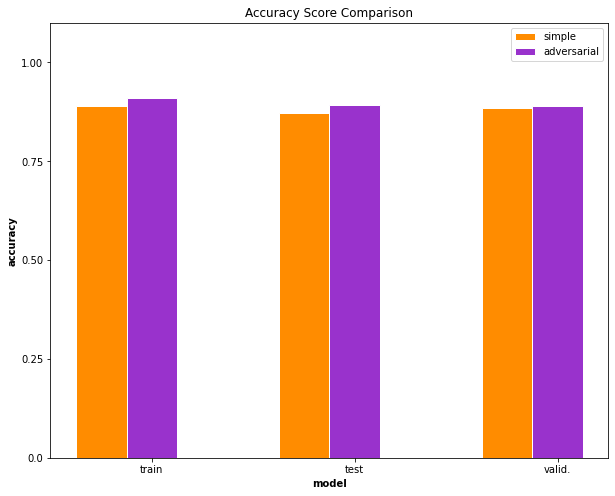

In [206]:
plot_metric = "accuracy score"
plot_simadv_comp(
    train_metrics_scores, test_metrics_scores, val_metrics_scores, 
    plot_metric, 
    "Accuracy Score Comparison", "accuracy",
    destination_folder + "accuracy_comp.png"
)

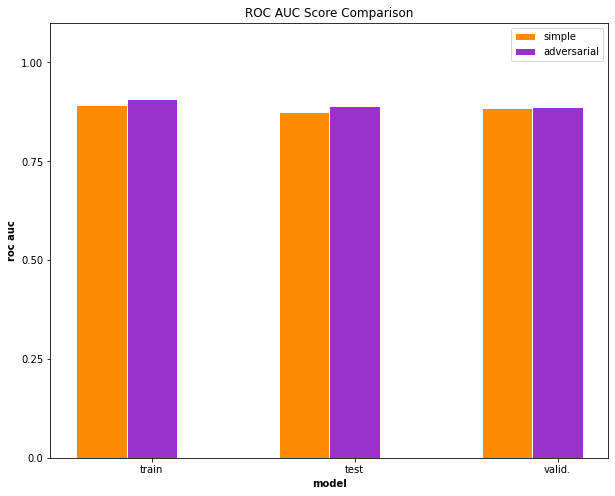

In [207]:
plot_metric = "roc auc"
plot_simadv_comp(
    train_metrics_scores, test_metrics_scores, val_metrics_scores,
    plot_metric, 
    "ROC AUC Score Comparison", "roc auc",
    destination_folder + "rocauc_comp.png"
)

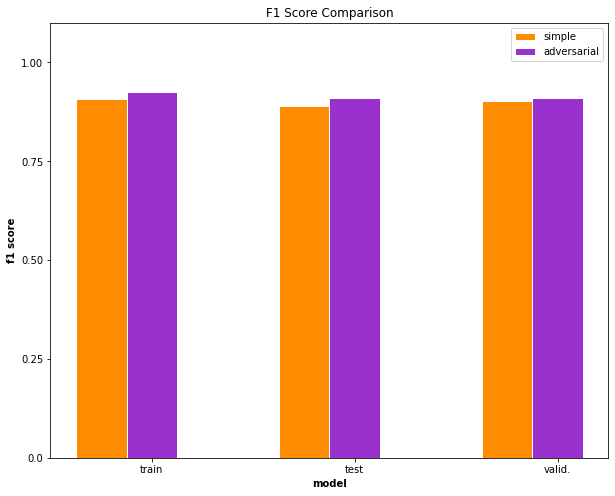

In [208]:
plot_metric = "f1 score"
plot_simadv_comp(
    train_metrics_scores, test_metrics_scores, val_metrics_scores,
    plot_metric, 
    "F1 Score Comparison", "f1 score",
    destination_folder + "f1_comp.png"
)

### Subclass Bias Performance

In [ ]:
comparing_keyword_climate = subclass_bias_scoring(unbal_data_test, "keyword", "climate change")

Model/Subset      Precision    Recall    Accuracy       F-1    ROC AUC    # TRUE REAL    # TRUE FAKE    # PRED REAL    # PRED FAKE    % TRUE REAL    % TRUE FAKE    % PRED REAL    % PRED FAKE
--------------  -----------  --------  ----------  --------  ---------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------
SIMPLE/FULL        0.921684  0.861981    0.872281  0.890834   0.875004           1545           2362           1698           2209       0.395444       0.604556       0.434605       0.565395
SIMPLE/ONLY        0.830189  0.830189    0.890244  0.830189   0.874554            111             53            111             53       0.676829       0.323171       0.676829       0.323171
SIMPLE/WOUT        0.923933  0.862711    0.871493  0.892273   0.874173           1434           2309           1587           2156       0.383115       0.616885       0.423991       0.576009
ADVERS/FULL        0.91955   0.900085    0.89

In [ ]:
comparing_keyword_business = subclass_bias_scoring(unbal_data_test, "keyword", "business")

Model/Subset      Precision    Recall    Accuracy       F-1    ROC AUC    # TRUE REAL    # TRUE FAKE    # PRED REAL    # PRED FAKE    % TRUE REAL    % TRUE FAKE    % PRED REAL    % PRED FAKE
--------------  -----------  --------  ----------  --------  ---------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------
SIMPLE/FULL        0.921684  0.861981    0.872281  0.890834   0.875004           1545           2362           1698           2209       0.395444       0.604556       0.434605       0.565395
SIMPLE/ONLY        0.9375    0.79646     0.829412  0.861244   0.845599             57            113             74             96       0.335294       0.664706       0.435294       0.564706
SIMPLE/WOUT        0.920965  0.865273    0.874231  0.892251   0.876521           1488           2249           1624           2113       0.39818        0.60182        0.434573       0.565427
ADVERS/FULL        0.91955   0.900085    0.89

In [ ]:
comparing_keyword_politics = subclass_bias_scoring(unbal_data_test, "keyword", "politics")

Model/Subset      Precision    Recall    Accuracy       F-1    ROC AUC    # TRUE REAL    # TRUE FAKE    # PRED REAL    # PRED FAKE    % TRUE REAL    % TRUE FAKE    % PRED REAL    % PRED FAKE
--------------  -----------  --------  ----------  --------  ---------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------
SIMPLE/FULL        0.921684  0.861981    0.872281  0.890834   0.875004           1545           2362           1698           2209       0.395444       0.604556       0.434605       0.565395
SIMPLE/ONLY        0.905292  0.668724    0.834325  0.769231   0.80976             691            486            818            359       0.587086       0.412914       0.694987       0.305013
SIMPLE/WOUT        0.924865  0.912047    0.888645  0.918411   0.874642            854           1876            880           1850       0.312821       0.687179       0.322344       0.677656
ADVERS/FULL        0.91955   0.900085    0.89

In [ ]:
comparing_keyword_science = subclass_bias_scoring(unbal_data_test, "keyword", "science")

Model/Subset      Precision    Recall    Accuracy       F-1    ROC AUC    # TRUE REAL    # TRUE FAKE    # PRED REAL    # PRED FAKE    % TRUE REAL    % TRUE FAKE    % PRED REAL    % PRED FAKE
--------------  -----------  --------  ----------  --------  ---------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------
SIMPLE/FULL        0.921684  0.861981    0.872281  0.890834   0.875004           1545           2362           1698           2209       0.395444       0.604556       0.434605       0.565395
SIMPLE/ONLY        0.966102  0.897638    0.885906  0.930612   0.85791              22            127             31            118       0.147651       0.852349       0.208054       0.791946
SIMPLE/WOUT        0.919177  0.859955    0.87174   0.888581   0.874495           1523           2235           1667           2091       0.405269       0.594731       0.443587       0.556413
ADVERS/FULL        0.91955   0.900085    0.89

In [ ]:
comparing_keyword_china = subclass_bias_scoring(unbal_data_test, "keyword", "china")

Model/Subset      Precision    Recall    Accuracy       F-1    ROC AUC    # TRUE REAL    # TRUE FAKE    # PRED REAL    # PRED FAKE    % TRUE REAL    % TRUE FAKE    % PRED REAL    % PRED FAKE
--------------  -----------  --------  ----------  --------  ---------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------
SIMPLE/FULL        0.921684  0.861981    0.872281  0.890834   0.875004           1545           2362           1698           2209       0.395444       0.604556       0.434605       0.565395
SIMPLE/ONLY        0.911504  0.876596    0.853731  0.893709   0.838298            100            235            109            226       0.298507       0.701493       0.325373       0.674627
SIMPLE/WOUT        0.922844  0.860367    0.87402   0.890511   0.877242           1445           2127           1589           1983       0.404535       0.595465       0.444849       0.555151
ADVERS/FULL        0.91955   0.900085    0.89

In [ ]:
comparing_keyword_trump = subclass_bias_scoring(unbal_data_test, "has_mk_donald trump", 1)

Model/Subset      Precision    Recall    Accuracy       F-1    ROC AUC    # TRUE REAL    # TRUE FAKE    # PRED REAL    # PRED FAKE    % TRUE REAL    % TRUE FAKE    % PRED REAL    % PRED FAKE
--------------  -----------  --------  ----------  --------  ---------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------
SIMPLE/FULL        0.921684  0.861981    0.872281  0.890834   0.875004           1545           2362           1698           2209       0.395444       0.604556       0.434605       0.565395
SIMPLE/ONLY        0.896104  0.657143    0.903297  0.758242   0.817143            350            105            378             77       0.769231       0.230769       0.830769       0.169231
SIMPLE/WOUT        0.922608  0.871511    0.868192  0.896332   0.866718           1195           2257           1320           2132       0.346176       0.653824       0.382387       0.617613
ADVERS/FULL        0.91955   0.900085    0.89

In [ ]:
comparing_keyword_obama = subclass_bias_scoring(unbal_data_test, "has_mk_barack obama", 1)

Model/Subset      Precision    Recall    Accuracy       F-1    ROC AUC    # TRUE REAL    # TRUE FAKE    # PRED REAL    # PRED FAKE    % TRUE REAL    % TRUE FAKE    % PRED REAL    % PRED FAKE
--------------  -----------  --------  ----------  --------  ---------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------
SIMPLE/FULL        0.921684  0.861981    0.872281  0.890834   0.875004           1545           2362           1698           2209       0.395444       0.604556       0.434605       0.565395
SIMPLE/ONLY        0.9       0.459184    0.805369  0.608108   0.717092            200             98            248             50       0.671141       0.328859       0.832215       0.167785
SIMPLE/WOUT        0.922186  0.879417    0.877805  0.900294   0.877255           1345           2264           1450           2159       0.372679       0.627321       0.401773       0.598227
ADVERS/FULL        0.91955   0.900085    0.89

In [ ]:
comparing_tag_russia = subclass_bias_scoring(unbal_data_test, "has_mk_russia", 1)

Model/Subset      Precision    Recall    Accuracy       F-1    ROC AUC    # TRUE REAL    # TRUE FAKE    # PRED REAL    # PRED FAKE    % TRUE REAL    % TRUE FAKE    % PRED REAL    % PRED FAKE
--------------  -----------  --------  ----------  --------  ---------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------
SIMPLE/FULL        0.921684  0.861981    0.872281  0.890834   0.875004           1545           2362           1698           2209       0.395444       0.604556       0.434605       0.565395
SIMPLE/ONLY        0.959813  0.975309    0.946759  0.967499   0.899177            243           1053            226           1070       0.1875         0.8125         0.174383       0.825617
SIMPLE/WOUT        0.885865  0.770817    0.835312  0.824346   0.835486           1302           1309           1472           1139       0.49866        0.50134        0.563769       0.436231
ADVERS/FULL        0.91955   0.900085    0.89

In [ ]:
comparing_tag_israel = subclass_bias_scoring(unbal_data_test, "has_mk_israel", 1)

Model/Subset      Precision    Recall    Accuracy       F-1    ROC AUC    # TRUE REAL    # TRUE FAKE    # PRED REAL    # PRED FAKE    % TRUE REAL    % TRUE FAKE    % PRED REAL    % PRED FAKE
--------------  -----------  --------  ----------  --------  ---------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------
SIMPLE/FULL        0.921684  0.861981    0.872281  0.890834   0.875004           1545           2362           1698           2209       0.395444       0.604556       0.434605       0.565395
SIMPLE/ONLY        0.9       0.75        0.849057  0.818182   0.840517             29             24             33             20       0.54717        0.45283        0.622642       0.377358
SIMPLE/WOUT        0.921882  0.863131    0.8726    0.89154    0.875167           1516           2338           1665           2189       0.393358       0.606642       0.432019       0.567981
ADVERS/FULL        0.91955   0.900085    0.89

In [ ]:
comparing_tag_trump = subclass_bias_scoring(unbal_data_test, "has_mk_donald trump", 1)

Model/Subset      Precision    Recall    Accuracy       F-1    ROC AUC    # TRUE REAL    # TRUE FAKE    # PRED REAL    # PRED FAKE    % TRUE REAL    % TRUE FAKE    % PRED REAL    % PRED FAKE
--------------  -----------  --------  ----------  --------  ---------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------
SIMPLE/FULL        0.921684  0.861981    0.872281  0.890834   0.875004           1545           2362           1698           2209       0.395444       0.604556       0.434605       0.565395
SIMPLE/ONLY        0.896104  0.657143    0.903297  0.758242   0.817143            350            105            378             77       0.769231       0.230769       0.830769       0.169231
SIMPLE/WOUT        0.922608  0.871511    0.868192  0.896332   0.866718           1195           2257           1320           2132       0.346176       0.653824       0.382387       0.617613
ADVERS/FULL        0.91955   0.900085    0.89

In [ ]:
comparing_tag_hillary = subclass_bias_scoring(unbal_data_test, "has_mk_hillary clinton", 1)

Model/Subset      Precision    Recall    Accuracy       F-1    ROC AUC    # TRUE REAL    # TRUE FAKE    # PRED REAL    # PRED FAKE    % TRUE REAL    % TRUE FAKE    % PRED REAL    % PRED FAKE
--------------  -----------  --------  ----------  --------  ---------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------
SIMPLE/FULL        0.921684  0.861981    0.872281  0.890834   0.875004           1545           2362           1698           2209       0.395444       0.604556       0.434605       0.565395
SIMPLE/ONLY        0.871795  0.419753    0.692308  0.566667   0.681467             88             81            130             39       0.52071        0.47929        0.769231       0.230769
SIMPLE/WOUT        0.922581  0.877685    0.880417  0.899573   0.88119            1457           2281           1568           2170       0.389781       0.610219       0.419476       0.580524
ADVERS/FULL        0.91955   0.900085    0.89

NOTE: comparisons on authors could be made, but all samples with author data happened to be labelled real, so comparision does not give much information for bias for/against that author. Plus, authors are directly related to the source domain, which is directly related to the label for the sample.